In [1]:
import ultraplot as uplt
import matplotlib as plt
import numpy as np
from sklearn.linear_model import TheilSenRegressor
import matplotlib.patches as patches
import pandas as pd

# Prepare Theoretical Data

In [2]:
x = np.linspace(0, 364, 365)

# Parameters for modified double logistic model
a = 0.2 # Minimum EVI
b = 0.8 # Range of EVI
c = 0.0007 # Slope of greendown trend
m_1 = -0.4 # Slope of first logistic
m_2 = -0.07 # Slope of second logistic
n_1 = 150 # Start of Season
n_2 = 290 # End of Season

normal_veg = a + (b - c*x) * ( 1/(1+np.exp(m_1*(x - n_1))) - 1/(1+np.exp(m_2*(x - n_2))) )


x_test = np.arange(150, 250)
y = a + (b - c*x_test) * ( 1/(1+np.exp(m_1*(x_test - n_1))) - 1/(1+np.exp(m_2*(x_test - n_2))) )

slope, intercept = np.polyfit(x_test, y, 1)
y_ols = slope*x + intercept

# Parameters of slight defoliation
b_d = 0.1 # Decrease in maximum EVI

slight_defol = a + (b - b_d - c*x) * ( 1/(1+np.exp(m_1*(x - n_1))) - 1/(1+np.exp(m_2*(x - n_2))) )


# Parameters of severe defoliation
d = 0.4 # Strength of defol
m_3 = 0.004 # Rate of defoliation
n_3 = 180 # ~ Date of Peak Defoliation

severe_defol = a + (b - b_d - c*x) * ( 1/(1+np.exp(m_1*(x - n_1))) - 1/(1+np.exp(m_2*(x - n_2))) ) - d*np.exp(-m_3*(x - n_3)**2)

# Modified parameters of off-season harvesting
n_h = 180
b_h = 0.3

harvest = a + (b - b_h - c*x) * ( 1/(1+np.exp(m_1*(x - n_h))) - 1/(1+np.exp(m_2*(x - n_2))) )

In [3]:
x_test = np.arange(150, 250)
y = a + (b - c*x_test) * ( 1/(1+np.exp(m_1*(x_test - n_1))) - 1/(1+np.exp(m_2*(x_test - n_2))) )

theil = TheilSenRegressor()
theil.fit(x_test.reshape(-1, 1), y)

y_theil = theil.predict(x.reshape(-1, 1))

In [4]:
def plot_normal_theory(ax, lw, lw2):
    ax.plot(x, normal_veg, linewidth=lw, label='Normal', color='shamrock green')
    ax.plot(x, y_theil,    color='black', linewidth=lw2, linestyle='dashed', label='Within Season')

    # SOS/EOS
    rect = patches.Rectangle((150, 0), 140, 1, facecolor='lightgray', label='Growing Season')
    ax.add_patch(rect)

    ax.format(ylim=[0,1], ylabel='EVI',
              xlim=[0, 365], xlocator=[0, 180, 360])

In [5]:
def plot_logging_theory(ax, lw):
    ax.plot(x, normal_veg, linewidth=lw, label='Normal', color='shamrock green')
    ax.plot(x, harvest,    linewidth=lw, label='Winter Harvest', color='brown')

    # Normal SOS/EOS
    #rect = patches.Rectangle((150, 0), 140, 1, facecolor='lightgray', label='Typical Growing Season')
    #ax.add_patch(rect)

    # Green up Period
    rect = patches.Rectangle((130, 0),40, 1, facecolor='gray6', label='Greenup Period')
    ax.add_patch(rect)

    ax.format(ylim=[0,1], ylabel='EVI',
              xlim=[0, 365], xlocator=[0, 180, 360])

In [32]:
def plot_defoliation_theory(ax, lw):
    ax.plot(x, normal_veg, linewidth=lw, label='Normal', color='shamrock green')
    ax.plot(x, slight_defol, linewidth=lw, label='Slight Defol', color='purple')
    ax.plot(x, severe_defol, linewidth=lw, label='Severe Defol', color='blue')

    # Defoliation Period
    rect = patches.Rectangle((160, 0), 40, 1, facecolor='gray6', label='Defol. Period')
    ax.add_patch(rect)

    ax.format(ylim=[0,1], ylabel='EVI',
              xlim=[0, 365], xlocator=[0, 180, 360])

In [7]:
def plot_defol_anomaly_theory(ax, lw, lw2):
    normal_anom = normal_veg - y_theil
    slight_anom = slight_defol - y_theil
    severe_anom = severe_defol - y_theil

    growing_season = (x > 160) & (x < 180)

    ax.plot(x, y_theil - y_theil,    color='black', linewidth=lw2, linestyle='dashed', label='Within Season', zorder=2)
    ax.plot(x, normal_anom, linewidth=lw, label='Normal', color='shamrock green', zorder=0)
    ax.plot(x, slight_anom, linewidth=lw, label='Slight Defol', color='purple', zorder=0)
    ax.plot(x, severe_anom, linewidth=lw, label='Severe Defol', color='blue', zorder=0)


    #ax.hlines(normal_anom[growing_season].mean(), 160, 200, color='green', linestyle='dashed', linewidth=3)
    #ax.hlines(slight_anom[growing_season].mean(), 160, 200, color='yellow orange', linestyle='dashed', linewidth=3)
    #ax.hlines(severe_anom[growing_season].mean(), 160, 200, color='red', linestyle='dashed', linewidth=3)

    ax.format(ylim=[-0.6,0.2], ylabel='EVI Anomaly',
              xlim=[160, 200], xlabel='Day of Year')

# Prepare Observation Data

In [8]:
winter = pd.read_csv('./Data/Winter_Harvest.csv')
winter = winter.melt(id_vars=['doy']).dropna().reset_index()
winter['variable'] = winter['variable'].apply(int)
harvest_mask = winter['variable'] == 2020 

defol = pd.read_csv('./Data/Severe_Defol.csv')
defol = defol.melt(id_vars=['doy']).dropna().reset_index()
defol['variable'] = defol['variable'].apply(int)
defol_mask = defol['variable'] == 2021

slope = -0.0010300187168904816
offset = 0.9250908551069817

defol['pred'] = slope*defol['doy'] + offset
defol['anom'] = defol['value'] - defol['pred']

doy_mask = (defol['doy'] >= 160) & (defol['doy'] <= 200)
healthy = defol.loc[(~defol_mask) & doy_mask, 'anom'].mean()
defoliated = defol.loc[defol_mask & doy_mask, 'anom'].mean()

In [9]:
def plot_normal_observation(ax, ms, lw2):
    ax.scatter(defol['doy'], defol['value'], markersize=ms, label='Normal', color='shamrock green')

    x = np.linspace(0, 365)
    y = slope*x + offset
    ax.plot(x, y, linewidth=lw2, color='black', linestyle='dashed', label='Within Season')

    # SOS/EOS
    rect = patches.Rectangle((150, 0), 140, 1, facecolor='lightgray', label='Growing Season', zorder=0)
    ax.add_patch(rect)

    ax.format(ylim=[0, 1], ylabel='',
              xlim=[0, 365], xlocator=[0, 180, 360], xlabel='')

In [10]:
def plot_logging_observation(ax, ms):
    ax.scatter(winter.loc[~harvest_mask, 'doy'], winter.loc[~harvest_mask, 'value'], markersize=ms, label='Normal', color='shamrock green')
    ax.scatter(winter.loc[harvest_mask, 'doy'], winter.loc[harvest_mask, 'value'],    markersize=ms, label='Winter Harvest', color='brown')

    # Winter Harvesting SOS/EOS
    rect = patches.Rectangle((130, 0), 40, 1, facecolor='gray6', label='Greenup Period', zorder=0)
    ax.add_patch(rect)

    ax.format(ylim=[0,1], ylabel='',
              xlim=[0, 365], xlocator=[0, 180, 360], xlabel='')

In [29]:
def plot_defoliation_observation(ax, ms):
    ax.scatter(defol.loc[~defol_mask, 'doy'], defol.loc[~defol_mask, 'value'], markersize=ms, label='Normal', color='shamrock green')
    ax.scatter(defol.loc[defol_mask, 'doy'], defol.loc[defol_mask, 'value'], markersize=ms, label='Severe Defol', color='blue')

    doy_min = 156
    doy_max = 278
    # SOS/EOS
    # rect = patches.Rectangle((doy_min, 0), doy_max - doy_min, 1, facecolor='lightgray', label='Growing Season', zorder=0)
    # ax.add_patch(rect)

    # Defoliation Period
    rect = patches.Rectangle((160, 0), 40, 1, facecolor='gray6', label='Defol. Period', zorder=0)
    ax.add_patch(rect)

    ax.format(ylim=[0, 1], ylabel='',
              xlim=[0, 365], xlocator=[0, 180, 360], xlabel='')

In [12]:
def plot_defol_anomaly_observation(ax, ms, lw2):
    ax.scatter(defol.loc[~defol_mask, 'doy'], defol.loc[~defol_mask, 'anom'], markersize=ms, label='Normal', color='shamrock green')
    #ax.plot(x, slight_defol, linewidth=5, label='Slight Defol', color='yellow orange')
    ax.scatter(defol.loc[defol_mask, 'doy'], defol.loc[defol_mask, 'anom'], markersize=ms, label='Severe Defol', color='blue')

    ax.hlines(0, 160, 200, color='lightgray', linewidth=lw2, zorder=0)
    ax.hlines(healthy, 160, 200, color='shamrock green', linestyle='dashed', linewidth=2)
    ax.hlines(defoliated, 160, 200, color='blue', linestyle='dashed', linewidth=2)

    ax.format(ylim=[-0.6, 0.2], ylabel='',
              xlim=[160, 200], xlabel='Day of Year')

# Plot Figure

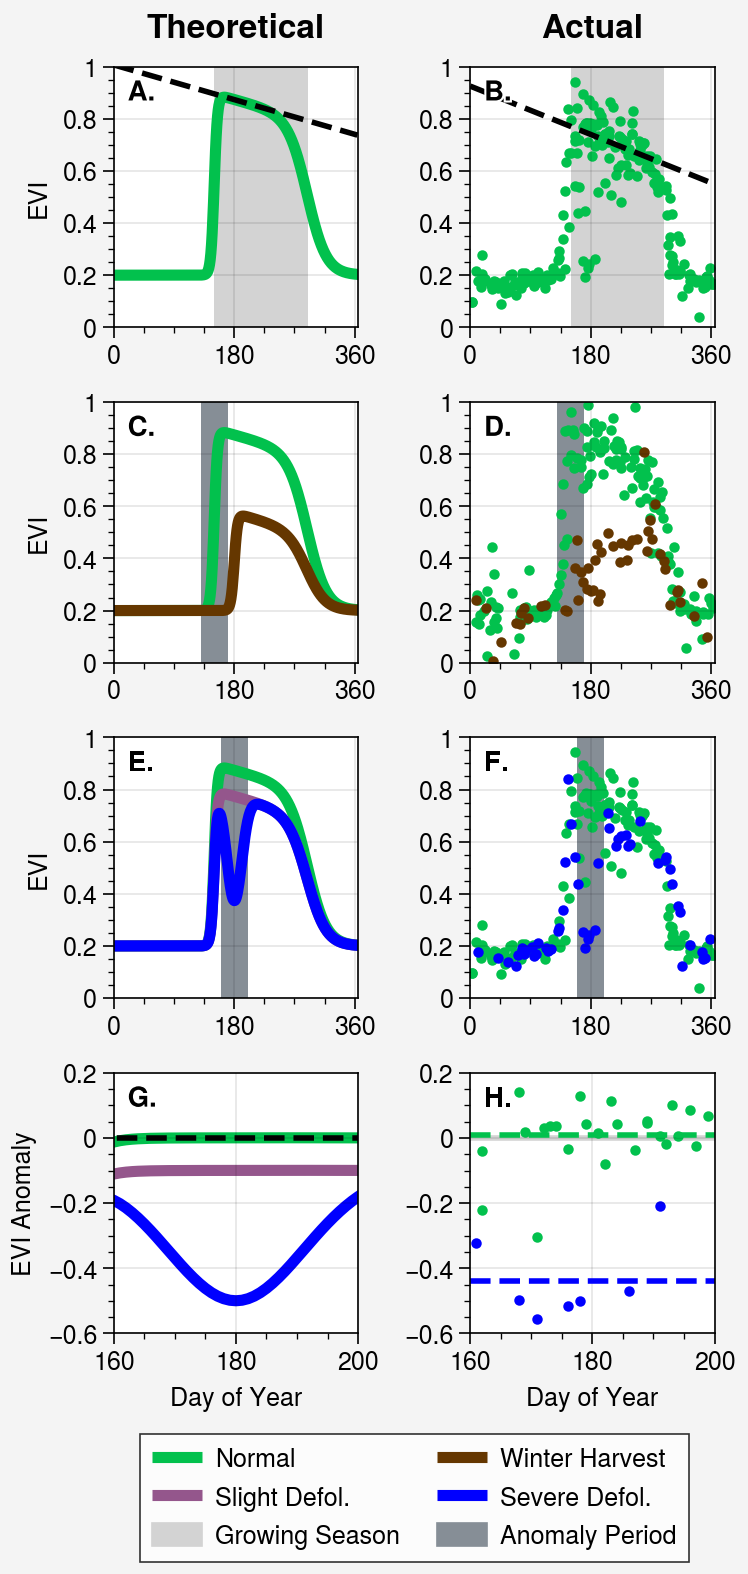

In [40]:
fig, axes = uplt.subplots(nrows=4, ncols=2, share=False, spany=False, figsize=('9.5cm', '20cm'))

axes.format(abc='A.', abcloc='ul')

lw = 4
lw2 = 2
plot_normal_theory(axes[0], lw, lw2)
plot_logging_theory(axes[2], lw)
plot_defoliation_theory(axes[4], lw)
plot_defol_anomaly_theory(axes[6], lw, lw2)

ms = 10
plot_normal_observation(axes[1], ms, lw2)
plot_logging_observation(axes[3], ms)
plot_defoliation_observation(axes[5], ms)
plot_defol_anomaly_observation(axes[7], ms, lw2)

norm_line = axes[0].plot([], [], color='shamrock green', label='Normal', lw=lw)
wh_line = axes[0].plot([], [], color='brown', label='Winter Harvest', lw=lw)
slight_line = axes[0].plot([], [], color='purple', label='Slight Defol.', lw=lw)
severe_line = axes[0].plot([], [], color='blue', label='Severe Defol.', lw=lw)


gs_patch = patches.Patch(color='lightgray', label='Growing Season')
ap_patch = patches.Patch(color='gray6', label='Anomaly Period')
fig.legend(handles=[norm_line, wh_line,
                    slight_line, severe_line, 
                    gs_patch, ap_patch], 
           loc='b',
           ncols=2)

fig.format(toplabels=['Theoretical', 'Actual'], 
           toplabels_kw={'size':12})
fig.savefig('./Figures/Methods_Half.png', dpi=300)

In [ ]:
import matplotlib
print('matplotlib: {}'.format(matplotlib.__version__))

In [14]:
np.array(uplt.to_rgb('brown'))*255

array([101.,  55.,   0.])